In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from flame_utils.FLAME_PyTorch_bonseyes.FLAME import FLAME
import torch
from collections import namedtuple

In [3]:
def reproject_vertices(vertices, projection, view, img_height):
    # Reproject vertices to image
    ones = np.ones((vertices.shape[0], 1))
    vertices_proj = np.concatenate((vertices, ones), axis=1)
    vertices_proj = projection @ view @ vertices_proj.T
    vertices_proj[:2] = vertices_proj[:2] / vertices_proj[3]
    vertices_proj[1] = img_height - vertices_proj[1]
    vertices_proj = vertices_proj.T

    return vertices_proj[:, :3]

def plot_mesh_on_image(
        img, 
        mesh,
        radius=2, 
        color=(255,255,255),
        mesh_step=1,
    ):
    if not isinstance(img, np.ndarray):
        img = np.array(img)
    img = img.copy()
    mesh = mesh.copy()

    for coord in mesh[::mesh_step, :]:
        point = (int(coord[0]), int(coord[1]))
        img = cv2.circle(
                    img, 
                    point, 
                    radius=radius, 
                    color=color
                )

    # img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    return Image.fromarray(img)

In [4]:
def get_flamelayer(
    flame_base_path="./flame_utils/FLAME_PyTorch_bonseyes"
):
    device = torch.device(f"cuda" if torch.cuda.is_available() else "cpu")

    file_path = os.path.join(flame_base_path,"flame_config.json")
    with open(file_path, 'r') as f:
        config = json.load(f)

    config["static_landmark_embedding_path"] = 'model/landmark_embedding.npy'
    
    config["device"] = device
    config["flame_model_path"] = os.path.join(flame_base_path, config["flame_model_path"])
    config["static_landmark_embedding_path"] = os.path.join(flame_base_path, config["static_landmark_embedding_path"])
    config["dynamic_landmark_embedding_path"] = os.path.join(flame_base_path, config["dynamic_landmark_embedding_path"])
    config = namedtuple('config', config.keys())(**config)

    return FLAME(config)


### Loading Data

In [5]:
base_data_dir = "/root/datasets/DAD-3DHeadsDataset"
datatool_tag = "train"
path = f"{datatool_tag}"
path = os.path.join(base_data_dir, path)
path

###################

file_path = f"{path}/{datatool_tag}.json"
file_path = os.path.join(base_data_dir, file_path)
with open(file_path, 'r') as f:
  data_json = json.load(f)
len(data_json)

'/root/datasets/DAD-3DHeadsDataset/train'

37840

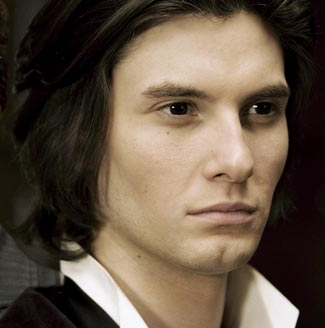

In [12]:
i = 26*1  # 7, 8
item = data_json[i]

# Item attributes
annotation_path = item["annotation_path"].split(f"{datatool_tag}/")[-1]
img_path = item["img_path"].split(f"{datatool_tag}/")[-1]
bbox = item["bbox"]

img = Image.open(os.path.join(path, img_path))
img_width, img_height = img.size
img_arr = np.array(img)
img

with open(os.path.join(path, annotation_path), 'r') as f:
  source_data = json.load(f)

# Get annotations data
vertices = np.array(source_data["vertices"])
view = np.array(source_data["model_view_matrix"])
projection = np.array(source_data["projection_matrix"])

# Pre-process
vertices_proj = reproject_vertices(vertices.copy(), projection, view, img_height)
img_crop = img_arr[bbox[1] : bbox[1] + bbox[3], bbox[0] : bbox[0] + bbox[2], :]  # crop image
vertices_crop = vertices_proj.copy()
vertices_crop[:,0] -= bbox[0] # adjust vertices based on cropping 
vertices_crop[:,1] -= bbox[1]

In [13]:
# import open3d as o3d
# import numpy as np
# from psbody.mesh import Mesh

In [14]:
# ball_pivoting = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting

# def lod_mesh_export(mesh, lods, extension=None, path=None):
#     mesh_lods={}
#     for i in lods:
#         mesh_lod = mesh.simplify_quadric_decimation(i)
#         if path:
#             o3d.io.write_triangle_mesh(path+"lod_"+str(i)+extension, mesh_lod)
#         mesh_lods[i]=mesh_lod
#         print("generation of "+str(i)+" LoD successful")
#     return mesh_lods

# def mesh_from_vertices(vertices, r_factor=1.0, saving_path=None):
#     # Create point cloud
#     pcd = o3d.geometry.PointCloud()
#     pcd.points = o3d.utility.Vector3dVector(vertices[:,:3])
#     pcd.estimate_normals(
#             search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30)
#         )

#     # Estimate mesh triangles
#     distances = pcd.compute_nearest_neighbor_distance()
#     avg_dist = np.mean(distances)
#     radius = r_factor * avg_dist
    
#     print(f"ball pivoting using radius={radius}")
#     mesh = ball_pivoting(pcd, o3d.utility.DoubleVector([radius, radius * 2]))
#     print(mesh)
    
#     if saving_path:
#         o3d.io.write_triangle_mesh(saving_path, mesh)

#     return mesh

In [15]:
# saving_dir = "saved_obj"
# saving_path = os.path.join(saving_dir, "mesh.obj")
# mesh = mesh_from_vertices(vertices, saving_path=saving_path)

In [16]:
# saving_dir = "saved_obj"

# np.save(os.path.join(saving_dir, "vertices"), vertices)
# np.save(os.path.join(saving_dir, "vertices_proj"), vertices_proj)
# np.save(os.path.join(saving_dir, "vertices_crop"), vertices_crop)

# np.save(os.path.join(saving_dir, "lms_crop"), lms_crop)
# np.save(os.path.join(saving_dir, "lms_proj"), lms_proj)
# np.save(os.path.join(saving_dir, "lms"), lms)

In [17]:
# flame_base_path = "./flame_utils/flame_fitting_bonseyes/"
# sys.path.append(flame_base_path)
# from flame_utils.flame_fitting_bonseyes.sbody.alignment.objectives import sample_from_mesh
# from flame_utils.flame_fitting_bonseyes.sbody.mesh_distance import ScanToMesh
# from flame_utils.flame_fitting_bonseyes.smpl_webuser.serialization import load_model
# from flame_utils.flame_fitting_bonseyes.sbody.robustifiers import GMOf

# filename = "saved_obj/mesh.obj"
# scan = Mesh(filename=filename)
# scan.v.shape
# scan.f.shape

# scan = Mesh(v=mesh.vertices, f=mesh.triangles)
# scan.v.shape
# scan.f.shape

# ####################

# model_path = os.path.join(flame_base_path, "model/generic_model.pkl")
# model = load_model(model_path)

# gmo_sigma = 1e-4

# sampler = sample_from_mesh(scan, sample_type='vertices')
# s2m = ScanToMesh(scan, model, model.f, scan_sampler=sampler, rho=lambda x: GMOf(x, sigma=gmo_sigma))
# s2m.shape

### Vertices 2 Landmarks: using FLAME Indices and Face models

In [18]:
flame_base_path = "./flame_utils/FLAME_PyTorch_bonseyes"
flamelayer = get_flamelayer(flame_base_path=flame_base_path)

creating the FLAME Decoder
... Finished FLAME Decoder creation


In [19]:
lms_crop = flamelayer.flame_vertices2landmarks(vertices_crop)
lms_crop = lms_crop[0].detach().cpu().numpy()
lms_crop.shape

lms_proj = flamelayer.flame_vertices2landmarks(vertices_proj)
lms_proj = lms_proj[0].detach().cpu().numpy()
lms_proj.shape

lms = flamelayer.flame_vertices2landmarks(vertices)
lms = lms[0].detach().cpu().numpy()
lms.shape

(68, 3)

(68, 3)

(68, 3)

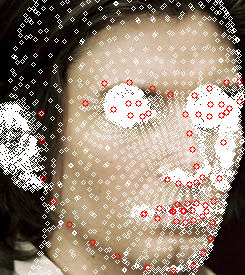

In [20]:
img_plot = img_crop.copy()
img_vertices = vertices_crop.copy()
img_plot = plot_mesh_on_image(img_plot, img_vertices)

img_vertices = lms_crop.copy()
img_plot = plot_mesh_on_image(img_plot, img_vertices, radius=3, color=(255,0,0))
img_plot

### Landmarks 2 FLAME Parameters: Using FLAME Fitting

In [21]:
import sys
sys.path.append("./flame_utils/flame_fitting_bonseyes")
from flame_utils.flame_fitting_bonseyes.fit_lmk3d import fit_flame_to_lms
from flame_utils.flame_fitting_bonseyes.fit_scan import fit_flame_to_scan

# lms_for_fit = lms_crop[17:].copy()
# lmk_unit = "na"
# vert_for_fit = vertices_crop.copy()
# scan_from_vert = True

lms_for_fit = lms[17:].copy()
lmk_unit = "na"
vert_for_fit = vertices.copy()
scan_from_vert=True

shape_num = 100  # 100
expr_num = 50  # 50
maxiter = 1000
model_path = os.path.join(flame_base_path, "model/generic_model.pkl")
lmk_emb_path = os.path.join(flame_base_path, "model/flame_static_embedding.pkl")

mesh_v, mesh_f, params, scale_factor = fit_flame_to_scan(
                            vert_for_fit,
                            lms_for_fit,
                            scan_from_vert=scan_from_vert,
                            lmk_unit=lmk_unit,
                            shape_num=shape_num,
                            expr_num=expr_num,
                            maxiter=maxiter,
                            model_path=model_path,
                            lmk_emb_path=lmk_emb_path,
                        )

# Post procesing
trans, pose = params["trans"], params["pose"]
shape, expr = params["shape"], params["expr"]
scale_factor_inv = 1 / scale_factor
mesh_v_scaled = scale_factor_inv * mesh_v
lms_for_fit_scaled = scale_factor_inv * lms_for_fit

print("Vertices Error:")
(np.sum( np.abs(vert_for_fit - mesh_v_scaled) ) ) / vert_for_fit.shape[0]

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
No scale specified - computing approximate scale based on the landmarks
Scale factor (unit='na'): 0.112676
Computing mesh from vertices
ball pivoting using radius=0.030245709532177714
TriangleMesh with 5023 points and 4936 triangles.
{'s2m': 6.0, 'lmk': 1.0, 'shape': 0.0001, 'expr': 0.0001, 'pose': 0.001}
>> Using ScanToMesh

step 1: start rigid fitting...
step 1: fitting done, in 4.682288 sec

step 2: start non-rigid fitting...
step 2: fitting done, in 176.692685 sec

Vertices Error:


0.049888194902029094

In [15]:
# mesh_v, mesh_f, params, scale_factor = fit_flame_to_lms(
#                             lms_for_fit,
#                             lmk_unit=lmk_unit,
#                             shape_num=shape_num,
#                             expr_num=expr_num,
#                             maxiter=maxiter,
#                             model_path=model_path,
#                             lmk_emb_path=lmk_emb_path,
#                         )

In [61]:
# Vertices fit: 99.197
# Scan fit: 73.339
# Scan fit + ALL params: 82.522
# Scan fit + hight weights: 40.834

Text(0.5, 1.0, 'Fitted')

Text(0.5, 1.0, 'GT')

Text(0.5, 1.0, 'Fitted (red) vs GT (blue)')

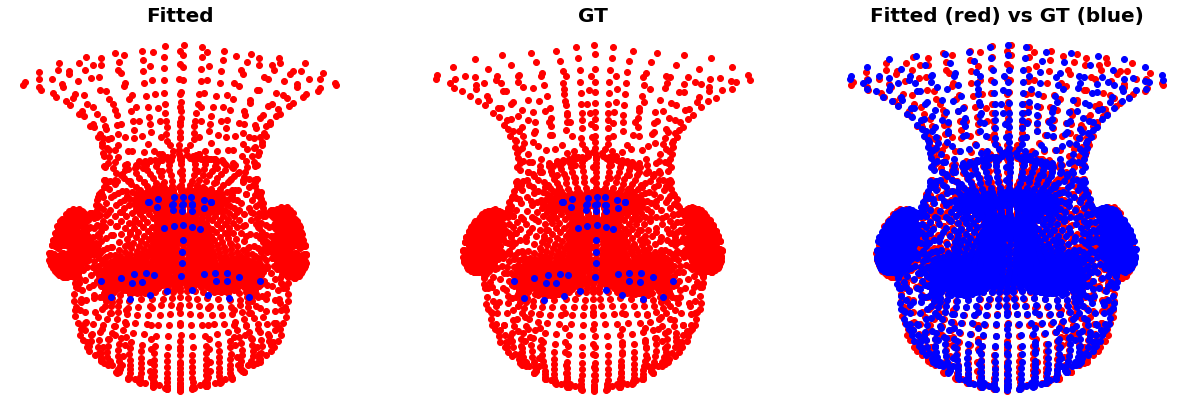

In [23]:
fig_s = 7
n_rows, n_cols = 1, 3
fit, ax = plt.subplots(n_rows, n_cols, figsize=(fig_s*n_cols, fig_s))
_ = [a.set_axis_off() for a in ax]

ax[0].scatter(mesh_v_scaled[:,0], -mesh_v_scaled[:,1], color="red")
ax[0].scatter(lms_for_fit[:,0], -lms_for_fit[:,1], color="blue")
ax[0].set_title("Fitted", fontdict={'fontsize': 20, 'fontweight': 'bold'})

ax[1].scatter(vert_for_fit[:,0], -vert_for_fit[:,1], color="red")
ax[1].scatter(lms_for_fit[:,0], -lms_for_fit[:,1], color="blue")
ax[1].set_title("GT", fontdict={'fontsize': 20, 'fontweight': 'bold'})

ax[-1].scatter(mesh_v_scaled[:,0], -mesh_v_scaled[:,1], color="red")
ax[-1].scatter(vert_for_fit[:,0], -vert_for_fit[:,1], color="blue")
ax[-1].set_title("Fitted (red) vs GT (blue)", fontdict={'fontsize': 20, 'fontweight': 'bold'})

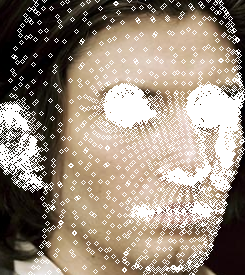

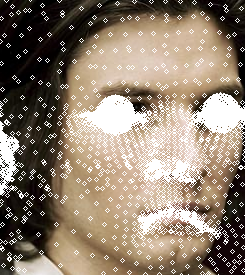

In [58]:
# Plot
img_plot = img_crop
img_vertices = vertices_crop
plot_mesh_on_image(img_plot, img_vertices)


img_plot = img_crop
# img_vertices = mesh_v_scaled_crop
img_vertices = mesh_v_scaled
plot_mesh_on_image(img_plot, img_vertices)

In [88]:
from math import cos, sin, sqrt

def _draw_3d_axis(
    img,
    yaw,
    pitch,
    roll,
    tdx=None,
    tdy=None,
    lm=None,
    lm_nose_idx=30,
    ax_colors=None,
    size=100,
    ):
    if (tdx is None) or (tdy is None):
        tdx = lm[0,lm_nose_idx]
        tdy = lm[1,lm_nose_idx]

    minx, maxx = np.min(lm[0, :]), np.max(lm[0, :])
    miny, maxy = np.min(lm[1, :]), np.max(lm[1, :])
    llength = sqrt((maxx - minx) * (maxy - miny))
    size = llength * 0.5

    # X-Axis pointing to right. drawn in red (Pitch)
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green (Yaw)
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue (Roll)
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    minus=0

    # Plot
    if ax_colors is None:
        # BGR scale
        ax_colors = [(0,0,255), (0,255,0), (255,0,0)]
    cv2.line(img, (int(tdx), int(tdy)-minus), (int(x1),int(y1)), ax_colors[0],4)
    cv2.line(img, (int(tdx), int(tdy)-minus), (int(x2),int(y2)), ax_colors[1],4)
    cv2.line(img, (int(tdx), int(tdy)-minus), (int(x3),int(y3)), ax_colors[2],4)

    return img


def _plot_head_pose(image, head_pose, lm_3d, ax_colors=None):
    pitch = head_pose[0] # red
    yaw = -1 * head_pose[1]  # green
    roll = head_pose[2]  # blue

    if not isinstance(image, np.ndarray):
        image = np.array(image)

    image = _draw_3d_axis(
        image.copy(),
        yaw,
        pitch,
        roll,
        lm=lm_3d,
        lm_nose_idx=17+13,
        ax_colors=ax_colors
    )

    return image

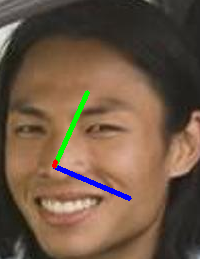

In [95]:
pitch = pose[2] # red
yaw = -1 * pose[0]  # green
roll = pose[1]  # blue

head_pose = [a * (180 / np.pi) for a in (pitch, yaw, roll)]
head_pose = [pose[1], pose[0], pose[2]]
img_pose = _plot_head_pose(img_crop, head_pose, lms_crop.T)
Image.fromarray(img_pose)

#### Old Code

In [ ]:
# keys = ["vertices", "lms", "type"]
# data = dict.fromkeys(keys)
# plot_data = []
# data["vertices"], data["lms"], data["type"] = (
#             mesh_v_scaled_proj,
#             lms_proj,
#             "Fitted",
# )
# plot_data.append(data)

In [ ]:
n = 100
step = 25

vertices_crop.shape
vertices_crop[:n:step]

mesh_v_scaled.shape
mesh_v_scaled[:n:step]

mesh_v.shape
mesh_v[:n:step]